In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../dataset/')
from dataset import AsbestosDataSet
import os 
from pathlib import Path
import json
from pycocotools.coco import COCO
from PIL import Image


In [2]:
ds = AsbestosDataSet('../../task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/JPEGImages/asbestos/stones/161220/',
              '../../task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationClass/asbestos/stones/161220/')

In [3]:
root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_12_11_09_08_29-segmentation mask 1.1 (1)'
root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)'
os.listdir(root)

['SegmentationObject',
 'JPEGImages',
 'annotations',
 'SegmentationClass',
 'ImageSets',
 'labelmap.txt']

In [4]:
example = ds[0]
print(type(example['image']), type(example['mask']))

<class 'PIL.BmpImagePlugin.BmpImageFile'> <class 'PIL.Image.Image'>


In [5]:
file = open(root +'/annotations/instances_default.json','r') 
text = file.read()
segmentation = json.loads(text)
print(segmentation.keys())
segmentation['categories']

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


[{'id': 1, 'name': 'stone', 'supercategory': ''},
 {'id': 2, 'name': 'asbest', 'supercategory': ''}]

In [7]:
labels = {}
for s in segmentation['annotations']:
    if s['image_id'] == 27:        
        labels[s['id']] = s['segmentation']     
print(len(labels))

18


2592 2048


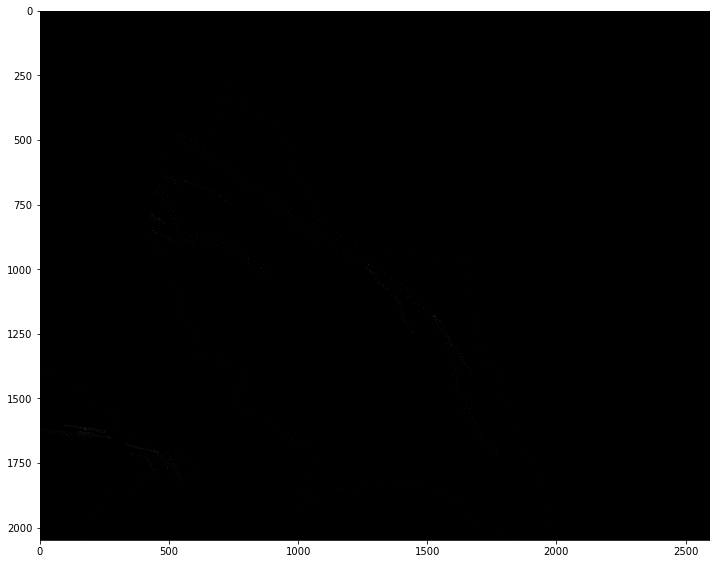

In [8]:
width = segmentation['images'][0]['width']
height = segmentation['images'][0]['height']
print(width, height)

x, y  = [],[]
for idx, s in labels.items():
    if len(s) < 2:
        x.extend(s[0][::2])
        y.extend(s[0][1::2])
    else:
        print('Er')

arr_mask = np.zeros((height, width), dtype = np.float64)
for x_c, y_c in zip(x,y):
    arr_mask[int(y_c - 1), int(x_c - 1),] = 255
fig = plt.figure(figsize = (12,10))
plt.imshow(arr_mask,  cmap='gray', vmin = 0, vmax = 255)

##Конверт

In [94]:
def create_annotation_mask(coco_set, img_indx, image_root, category_name = 'asbest'):
    cat_ids  = coco_set.getCatIds(catNms=[category_name])
    img_ids  = coco_set.getImgIds(catIds=cat_ids );
    image_dict = coco_set.loadImgs(img_indx)[0]
    image = np.array(Image.open(os.path.join(image_root, image_dict['file_name'])))
    ann_ids = coco_set.getAnnIds(imgIds=image_dict['id'], catIds=cat_ids, iscrowd=None)
    anns = coco_set.loadAnns(ann_ids)
    mask = coco_set.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco_set.annToMask(anns[i])
    return mask

In [95]:
coco_set = COCO('/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/annotations/instances_default.json')

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [96]:
mask = create_annotation_mask(coco_set, 1, root)

In [114]:
segmentaion_root = '/home/kirill/Учеба/asbestos/task_asbestos_stone_161220-2021_01_13_12_39_03-segmentation mask 1.1 (1)/SegmentationAsbest'
for idx, image_name in coco_set.imgs.items():
    name = image_name['file_name'].split('/')[-1].split('.')[0]
    try:
        mask = create_annotation_mask(coco_set, idx, root)
        plt.imsave(os.path.join(segmentaion_root, name + '.jpeg'), mask, cmap='Greys')
    except:
        print(idx)
        
    if idx%10 == 0:
        print(idx)

10
20
30
40
50
56
